# Generate summary statistics for figure 3.

In [47]:
# General dependencies
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pickle as pkl
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from math import isnan

In [3]:
# This is where to find the data
data_dir = "/Volumes/condor/lthomas/Projects/Thesis_analysis/STRF_SMRF_PKLs_2512"
# Read all the pkl files in the data directory
data_files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]

# THe file that has the information about unit types
histo_file = "/Volumes/condor/lthomas/Projects/Thesis_analysis/all_units_unit_types_260130.pkl"
with open(histo_file, 'rb') as infile:
    histoDF  = pkl.load(infile)

sites = np.unique(histoDF['site'])

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_78122/4084998930.py:9: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  histoDF  = pkl.load(infile)


In [4]:
# Open one data file to check it out
file_path = os.path.join(data_dir, data_files[0])
with open(file_path, 'rb') as infile:
    dataFrame  = pkl.load(infile)
dataFrame.keys()

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_78122/3590087964.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Index(['nwb_file_identifier', 'unit', 'r2Ceil', 'r2segModel', 'r2segIDModelLG',
       'r2segIDModelDG', 'r2segIDModelLGMPS', 'r2segIDModelDGMPS', 'r2STRF',
       'snr', 'f', 'snrEstf', 'cumInfo', 'totWeight', 'Laguerre_args',
       'dogs_args', 'pca_spect', 'pca_mps', 'strfModel', 'segModel',
       'segIDModelLG', 'segIDModelDG', 'segIDModelLGMPS', 'segIDModelDGMPS',
       'unit_id', 'error', 'nwb_file', 'bird'],
      dtype='object')

In [5]:
# Some rows have Nan?  Like row for unit_id 6 in this first file
for i, row in dataFrame.iterrows():
    if not isnan(row['snr']):
        print(row['nwb_file'], row['bird'], int(row['unit']), row['snr'], row['cumInfo'][-1])

XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 4 0.20320140862572209 12.854322601878135
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 5 0.29850280252344513 22.167637182193833
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 9 0.17277894870124805 16.187519792394898
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 11 0.08672545608805186 5.918552325438442
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 12 0.1466952034216828 7.080080433407732
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 13 0.053373375860158064 2.2277453692240137
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 18 0.3317059755697242 20.350909401328394
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 19 0.18818018625130725 5.427422546275835
XXXLbl116XF_site2_251017_130550_op_pb_ks4_lat_251102 XXXLbl116XF 21 0.15365924132517145 12.522597323744318
XXXLbl116XF_site2_251017_130550_op_pb_ks4_la

In [6]:
bird = 'BlaBla3637M'
good_site = 'BlaBla3736M_d2_240815_152202'   #  Note the name of the bird in site is different
unit = 0
# unit_type_row = histoDF[(histoDF['site'] == good_site) & (histoDF['unit_id'] == unit) & (histoDF['bird'] == bird)]
unit_type_row = histoDF[ (histoDF['bird'] == bird)]
print(unit_type_row['unit_id'].iloc[0], unit_type_row['unit_type'].iloc[0])

0 bs


In [7]:
# Store all the data in numpy arrays

snrs = []
infos = []
units = []
birds = []
nwbFiles = []
rate = []
data_length = []
r2Ceils = []
r2Segs = []
r2segIds = []
r2STRFs = []
unit_types = []
cumInfoWindow = 4  # Number of points to consider for plateau detection to correct for high-frequency noise in coherence based information.  


for f in data_files:
    file_path = os.path.join(data_dir, f)
    with open(file_path, 'rb') as infile:
        dataFrame  = pkl.load(infile)
    
    for i, row in dataFrame.iterrows():
        if not isnan(row['snr']):
            snrs.append(row['snr'])
            # Find first plateau value in cumInfo
            cumInfo = row['cumInfo']
            
            plateau_start = -1
            foundZero = False
            for i in range(1, len(cumInfo) - cumInfoWindow):
                if cumInfo[i] == cumInfo[i-1]:  # If zero change assume plateau
                    if not foundZero:
                        plateau_start = i-1
                        foundZero = True
                    if i - plateau_start == cumInfoWindow:  # Found platueau
                        # print(f"Found plateau for unit {row['unit']} at index {plateau_start} with value {cumInfo[plateau_start]} instead of {cumInfo[-1]}")
                        break
                else:
                    plateau_start = -1  # Reset if non-zero found
                    foundZero = False
            infos.append(cumInfo[plateau_start])   # Take the value of the plateau.

            units.append(int(row['unit']))
            birds.append(row['bird'])  
            rate.append(row['segModel']['yavg'])
            data_length.append(row['totWeight'])
            nwbFiles.append(row['nwb_file'])
            r2Ceils.append(row['r2Ceil'])
            r2Segs.append(row['r2segModel'])
            r2segIds.append(row['r2segIDModelLG'])
            r2STRFs.append(row['r2STRF'])

            site_info = row['nwb_file']
            good_site = None
            for site in sites:
                if site in row['nwb_file']:
                    good_site = site
                    break
            bird = row['bird']
            #   Fix bird if 'BlaBla3637M'
            if bird == 'BlaBla3736M':
                bird = 'BlaBla3637M'
            site_unit_info = histoDF[(histoDF['site'] == good_site)  & (histoDF['bird'] == bird)]
            if len(site_unit_info) == 0:
                print(f"Site info not found for bird {row['bird']}, site {good_site}")
            else:
                unit_type_row = histoDF[(histoDF['site'] == good_site) & (histoDF['unit_id'] == row['unit']) & (histoDF['bird'] == bird)]
                if len(unit_type_row) == 1:
                    unit_types.append(unit_type_row['unit_type'].iloc[0])
                else:
                    print(f"Unit type not found for bird {row['bird']}, site {good_site}, unit {row['unit']}")
                    unit_types.append('un')

snrs = np.array(snrs)
infos = np.array(infos)
rate = np.array(rate)
data_length = np.array(data_length) 
r2Ceils = np.array(r2Ceils)
r2Segs = np.array(r2Segs)
r2segIds = np.array(r2segIds)
r2STRFs = np.array(r2STRFs)
units = np.array(units, dtype=int)
birds = np.array(birds)
nwbFiles = np.array(nwbFiles)
unit_types = np.array(unit_types)

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_78122/2113509122.py:21: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_pe

## Choosing Auditory vs Non-Auditory Units
We will chose auditory units based on thresholds of coherence, evoked rate and data size.

Number of units with SNR > 0.0 and Information > 6.0 and Rate > 1.0 and Data Size > 1000: 526/1367


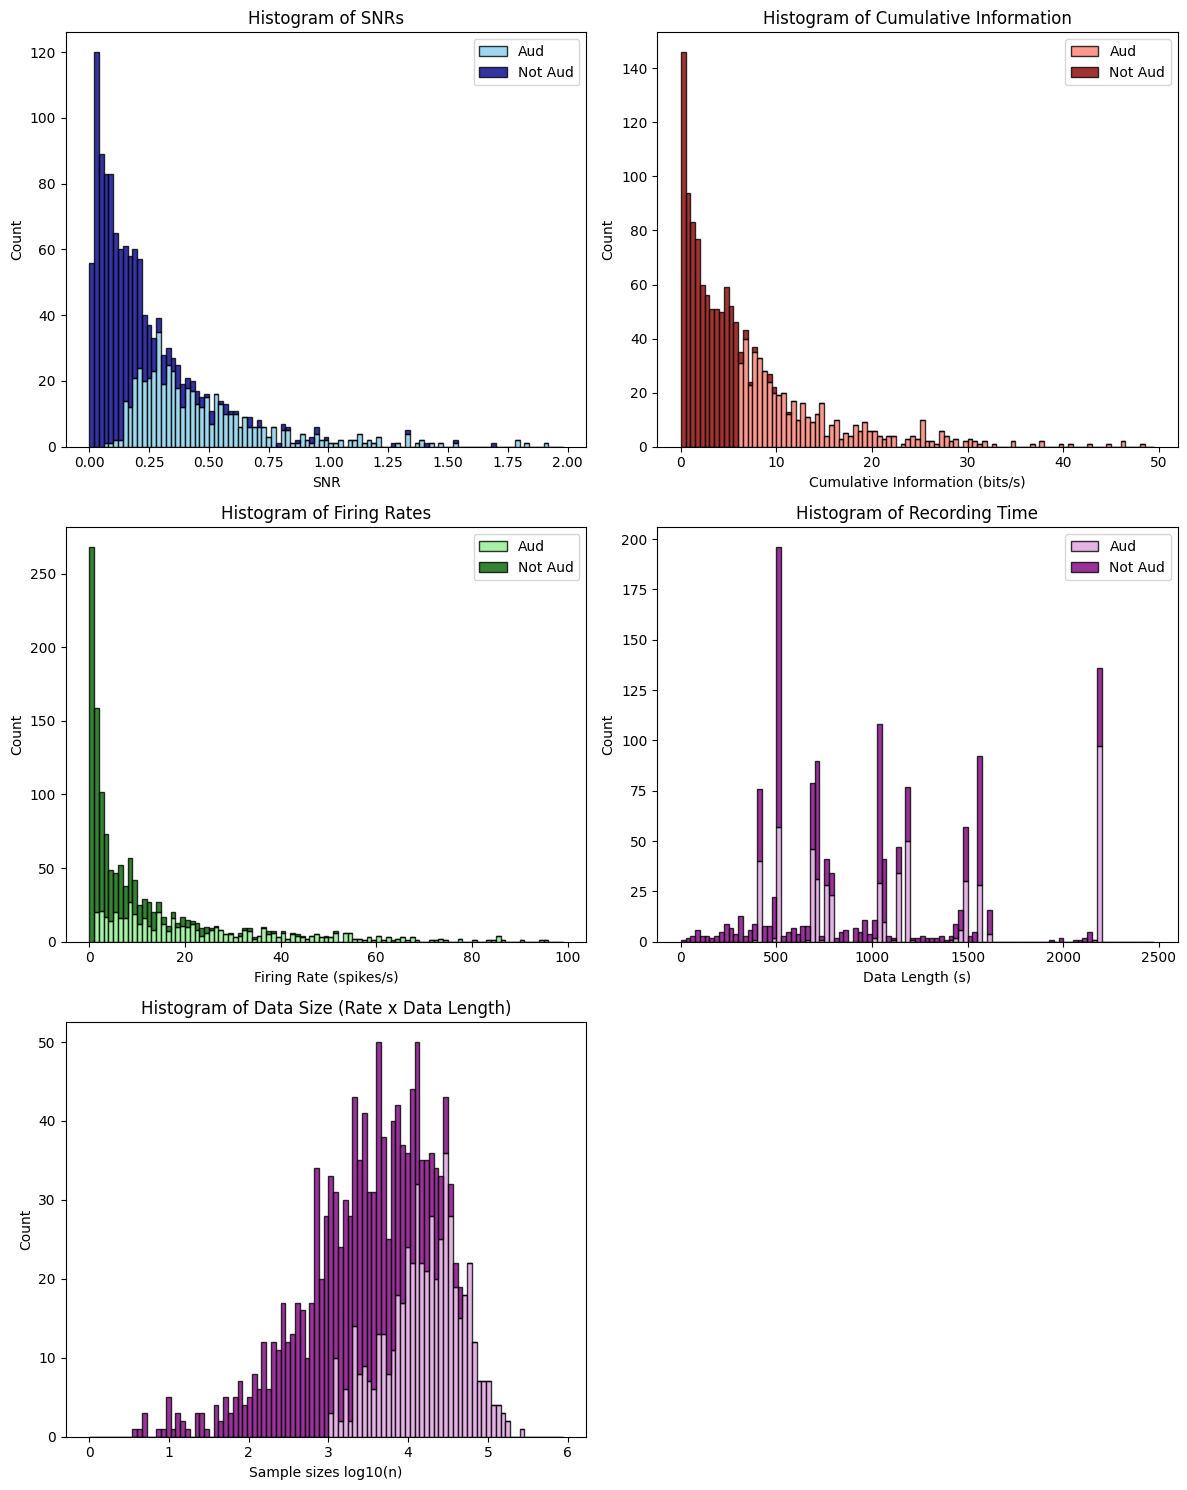

In [8]:
# Plot histograms
# We need to figure out thresholds for auditory units.  I propose this:

information_threshold = 6.0 # in bits/s
snr_threshold = 0.0 # unitless
rate_threshold = 1.0 # average evoked rate in spikes/s
data_size_threshold = 1000 # Requiring at leat 1000 spikes.

idx = (snrs > snr_threshold) & (infos > information_threshold) & (rate > rate_threshold) & (rate*data_length/1000 > data_size_threshold)
print(f"Number of units with SNR > {snr_threshold} and Information > {information_threshold} and Rate > {rate_threshold} and Data Size > {data_size_threshold}: {np.sum(idx)}/{len(snrs)}")

# Histograms of all parameters
plt.figure(figsize=(12, 15))

# Histogram of SNRs
plt.subplot(3, 2, 1)
bins = np.arange(0, 2.0, 2.0/100)
list_of_data = [snrs[idx], snrs[~idx]]
labels = ['Aud', 'Not Aud']
colors = ['skyblue', 'darkblue']
plt.hist(list_of_data, bins=bins, stacked=True, label=labels, color=colors, edgecolor='black', alpha=0.8)
plt.title('Histogram of SNRs')
plt.legend()
plt.xlabel('SNR')
plt.ylabel('Count')


# Histogram of cumulative information
plt.subplot(3, 2, 2)
bins = np.arange(0, 50, 50/100)
list_of_data = [infos[idx], infos[~idx]]
labels = ['Aud', 'Not Aud']
colors = ['salmon', 'darkred']
plt.hist(list_of_data, bins=bins, stacked=True, label=labels, color=colors, edgecolor='black', alpha=0.8)
plt.title('Histogram of Cumulative Information')
plt.legend()
plt.xlabel('Cumulative Information (bits/s)')
plt.ylabel('Count')

# Histogram of firing rates
plt.subplot(3, 2, 3)
bins = np.arange(0, 100.0, 100.0/100)
list_of_data = [rate[idx], rate[~idx]]
labels = ['Aud', 'Not Aud']
colors = ['lightgreen', 'darkgreen']
plt.hist(list_of_data, bins=bins, stacked=True, label=labels, color=colors, edgecolor='black', alpha=0.8)
plt.title('Histogram of Firing Rates')
plt.legend()
plt.xlabel('Firing Rate (spikes/s)')
plt.ylabel('Count')

# Histogram of recording time
plt.subplot(3, 2, 4)
bins = np.arange(0, 2500.0, 2500.0/100)
list_of_data = [data_length[idx]/1000, data_length[~idx]/1000]
labels = ['Aud', 'Not Aud']
colors = ['plum', 'purple']
plt.hist(list_of_data, bins=bins, stacked=True, label=labels, color=colors, edgecolor='black', alpha=0.8 )
plt.title('Histogram of Recording Time')
plt.legend()
plt.xlabel('Data Length (s)')
plt.ylabel('Count')

# Histogram of data size (rate x data length)
plt.subplot(3, 2, 5)
bins = np.arange(0, 6.0, 6.0/100)
list_of_data = [np.log10(rate[idx]*data_length[idx]/1000), np.log10(rate[~idx]*data_length[~idx]/1000)]
labels = ['Aud', 'Not Aud']
colors = ['plum', 'purple']
plt.hist(list_of_data, bins=bins, stacked=True, label=labels, color=colors, edgecolor='black', alpha=0.8 )
plt.title('Histogram of Data Size (Rate x Data Length)')
plt.legend
plt.xlabel('Sample sizes log10(n)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()




## Differences in information and rates between NS and BS neuros

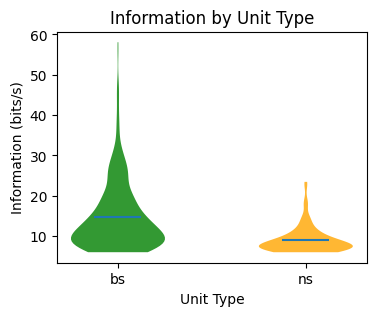

Mean Information for bs: 14.73 +- 0.409, ns: 9.01 +- 0.318
T-test between unit types bs and ns: t-statistic = 11.006, p-value = 5.09e-25


In [9]:
# Make a violin plot of cumulative information by unit type
unit_type_labels = ['bs', 'ns']
data_to_plot = [infos[(unit_types == ut) & idx] for ut in unit_type_labels] 
plt.figure(figsize=(4, 3))
parts = plt.violinplot(data_to_plot, showmeans=True, showextrema=False)
parts['bodies'][0].set_facecolor('green')
parts['bodies'][1].set_facecolor('orange')
parts['bodies'][0].set_alpha(0.8)
parts['bodies'][1].set_alpha(0.8)
plt.xticks([1, 2], unit_type_labels)
plt.title('Information by Unit Type')
plt.xlabel('Unit Type')
plt.ylabel('Information (bits/s)')
plt.show()

t_stat, p_val = stats.ttest_ind(data_to_plot[0], data_to_plot[1], equal_var=False)
print(f"Mean Information for bs: {np.mean(data_to_plot[0]):.2f} +- {np.std(data_to_plot[0])/np.sqrt(len(data_to_plot[0])):.3f}, ns: {np.mean(data_to_plot[1]):.2f} +- {np.std(data_to_plot[1])/np.sqrt(len(data_to_plot[1])):.3f}")
print(f"T-test between unit types bs and ns: t-statistic = {t_stat:.3f}, p-value = {p_val:.3g}")

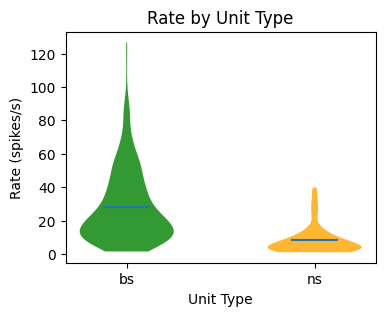

Mean Rate for bs: 28.13 +- 1.055, ns: 8.08 +- 0.828
T-test between unit types bs and ns: t-statistic = 14.910, p-value = 7.6e-41


In [10]:
# Make a violin plot of rate by unit type
unit_type_labels = ['bs', 'ns']
data_to_plot = [rate[(unit_types == ut) & idx] for ut in unit_type_labels] 
plt.figure(figsize=(4, 3))
parts = plt.violinplot(data_to_plot, showmeans=True, showextrema=False)
parts['bodies'][0].set_facecolor('green')
parts['bodies'][1].set_facecolor('orange')
parts['bodies'][0].set_alpha(0.8)
parts['bodies'][1].set_alpha(0.8)
plt.xticks([1, 2], unit_type_labels)
plt.title('Rate by Unit Type')
plt.xlabel('Unit Type')
plt.ylabel('Rate (spikes/s)')
plt.show()

t_stat, p_val = stats.ttest_ind(data_to_plot[0], data_to_plot[1], equal_var=False)
print(f"Mean Rate for bs: {np.mean(data_to_plot[0]):.2f} +- {np.std(data_to_plot[0])/np.sqrt(len(data_to_plot[0])):.3f}, ns: {np.mean(data_to_plot[1]):.2f} +- {np.std(data_to_plot[1])/np.sqrt(len(data_to_plot[1])):.3f}")
print(f"T-test between unit types bs and ns: t-statistic = {t_stat:.3f}, p-value = {p_val:.3g}")

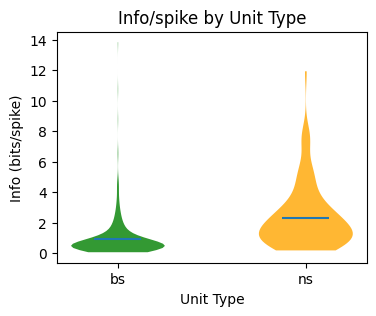

Mean Info/spike for bs: 0.93 +- 0.061, ns: 2.34 +- 0.200
T-test between unit types bs and ns: t-statistic = -6.667, p-value = 7.69e-10


In [64]:
# Make a violin plot of bits/spike by unit type
unit_type_labels = ['bs', 'ns']
data_to_plot = [infos[(unit_types == ut) & idx]/rate[(unit_types == ut) & idx] for ut in unit_type_labels] 
plt.figure(figsize=(4, 3))
parts = plt.violinplot(data_to_plot, showmeans=True, showextrema=False)
parts['bodies'][0].set_facecolor('green')
parts['bodies'][1].set_facecolor('orange')
parts['bodies'][0].set_alpha(0.8)
parts['bodies'][1].set_alpha(0.8)
plt.xticks([1, 2], unit_type_labels)
plt.title('Info/spike by Unit Type')
plt.xlabel('Unit Type')
plt.ylabel('Info (bits/spike)')
plt.show()

t_stat, p_val = stats.ttest_ind(data_to_plot[0], data_to_plot[1], equal_var=False)
print(f"Mean Info/spike for bs: {np.mean(data_to_plot[0]):.2f} +- {np.std(data_to_plot[0])/np.sqrt(len(data_to_plot[0])):.3f}, ns: {np.mean(data_to_plot[1]):.2f} +- {np.std(data_to_plot[1])/np.sqrt(len(data_to_plot[1])):.3f}")
print(f"T-test between unit types bs and ns: t-statistic = {t_stat:.3f}, p-value = {p_val:.3g}")

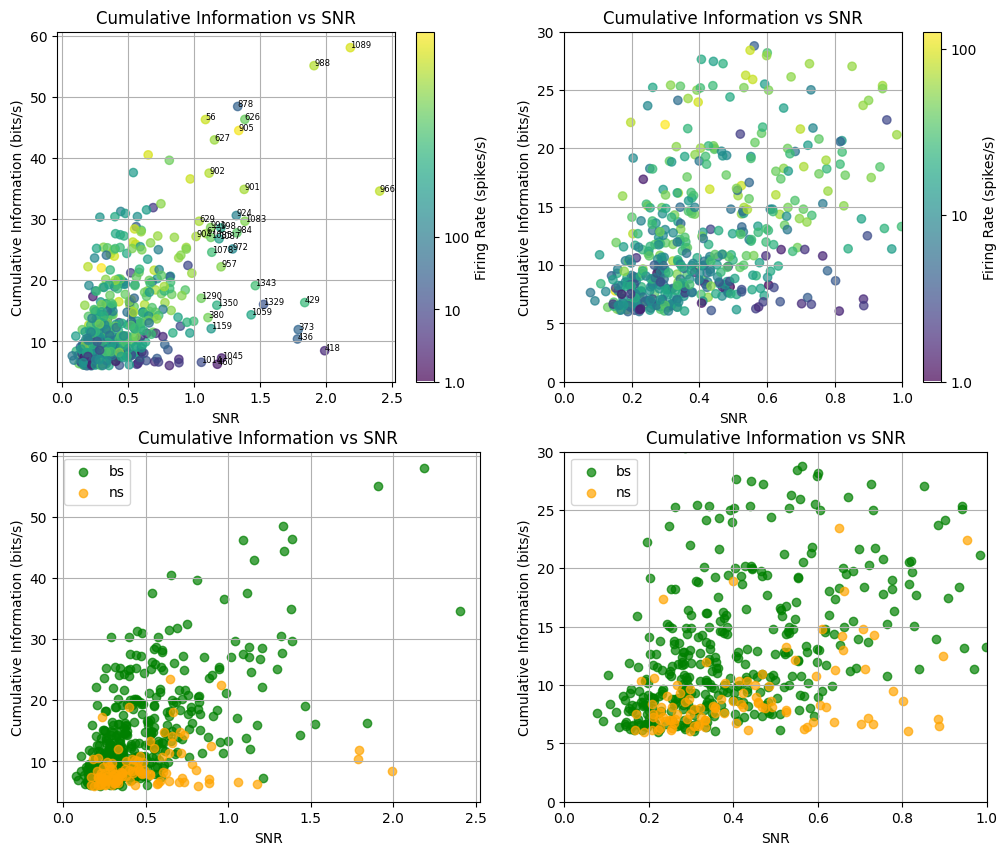

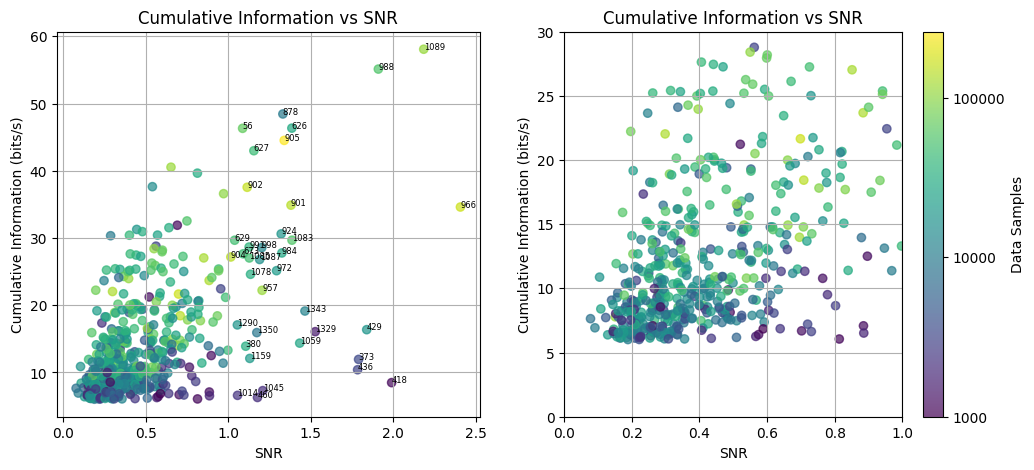

In [11]:
# Scatter plot of cumulative information vs SNR colored by rate

plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.scatter(snrs[idx], infos[idx], c = np.log(rate[idx]), cmap ='viridis', alpha=0.7)
plt.title('Cumulative Information vs SNR')
plt.xlabel('SNR')
plt.ylabel('Cumulative Information (bits/s)')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.grid(True)
# Add text labels for snr> 1
for i, snr in enumerate(snrs):
    if idx[i] and snr > 1.0:
        plt.text(snrs[i], infos[i], f"{i}", fontsize=6)

# Zoome in on low SNR region
plt.subplot(2,2,2)
plt.scatter(snrs[idx], infos[idx], c = np.log10(rate[idx]), cmap ='viridis', alpha=0.7)
plt.title('Cumulative Information vs SNR')
plt.xlim((0.0, 1.0))
plt.xlabel('SNR')
plt.ylim((0.0, 30.0))
plt.ylabel('Cumulative Information (bits/s)')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.grid(True)

# Repeat using unit_types for color
bs_idx = idx & (unit_types == 'bs')
ns_idx = idx & (unit_types == 'ns')
plt.subplot(2,2,3)
plt.scatter(snrs[bs_idx], infos[bs_idx], c = 'green', label='bs', alpha=0.7)
plt.scatter(snrs[ns_idx], infos[ns_idx], c = 'orange', label='ns', alpha=0.7)
plt.title('Cumulative Information vs SNR')
plt.xlabel('SNR')
plt.ylabel('Cumulative Information (bits/s)')
plt.legend()
plt.grid(True)

# Zoom in on low SNR region
plt.subplot(2,2,4)
plt.scatter(snrs[bs_idx], infos[bs_idx], c = 'green', label='bs', alpha=0.7)
plt.scatter(snrs[ns_idx], infos[ns_idx], c = 'orange', label='ns', alpha=0.7)
plt.title('Cumulative Information vs SNR')
plt.xlim((0.0, 1.0))
plt.xlabel('SNR')
plt.ylim((0.0, 30.0))
plt.ylabel('Cumulative Information (bits/s)')
plt.legend()
plt.grid(True)

plt.show()

# Scatter plot of cumulative information vs SNR colored by square root total data 

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(snrs[idx], infos[idx], c = np.log10(rate[idx]*data_length[idx]/1000), cmap ='viridis', alpha=0.7)
plt.title('Cumulative Information vs SNR')
plt.xlabel('SNR')
plt.ylabel('Cumulative Information (bits/s)')
plt.grid(True)
# Add text labels for snr> 1
for i, snr in enumerate(snrs):
    if idx[i] and snr > 1.0:
        plt.text(snrs[i], infos[i], f"{i}", fontsize=6)
plt.subplot(1,2,2)
plt.scatter(snrs[idx], infos[idx], c = np.log10(rate[idx]*data_length[idx]/1000), cmap ='viridis', alpha=0.7)
plt.title('Cumulative Information vs SNR')
plt.xlim((0.0, 1.0))
plt.xlabel('SNR')
plt.ylim((0.0, 30.0))
plt.ylabel('Cumulative Information (bits/s)')
cbar = plt.colorbar(label='Data Samples')
tickvalues = cbar.get_ticks()
cbar.set_ticks([3.0, 4.0, 5.0])
cbar.set_ticklabels([1000, 10000, 100000])
plt.grid(True)

plt.show()

In [19]:
units_to_label = [1014, 1045, 418]

for i_unit in units_to_label:
        print(f"Unit {i_unit} found in Bird {birds[i_unit]} - Unit {units[i_unit]} - File: {nwbFiles[i_unit]}: SNR={snrs[i_unit]}, Info={infos[i_unit]}, Rate={rate[i_unit]}, Data Length={data_length[i_unit]/1000} s")

Unit 1014 found in Bird HpiPur2667F - Unit 85 - File: HpiPur2667F_site03_240905_133829_pb_op_ks4_lat_250215: SNR=1.0560268414686038, Info=6.587551061004611, Rate=3.051791039660453, Data Length=762.926 s
Unit 1045 found in Bird BlaBla3736M - Unit 29 - File: BlaBla3736M_d4_240816_144048_ks4_lat_250416: SNR=1.2089784242617583, Info=7.290603870902894, Rate=1.4632716982106289, Data Length=1448.12 s
Unit 418 found in Bird BlaBla3736M - Unit 104 - File: BlaBla3736M_d1_240815_124122_ks4_lat_250215: SNR=1.9897697360268354, Info=8.4836877669742, Rate=1.7258354109170844, Data Length=659.14 s


/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_78122/495951639.py:11: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

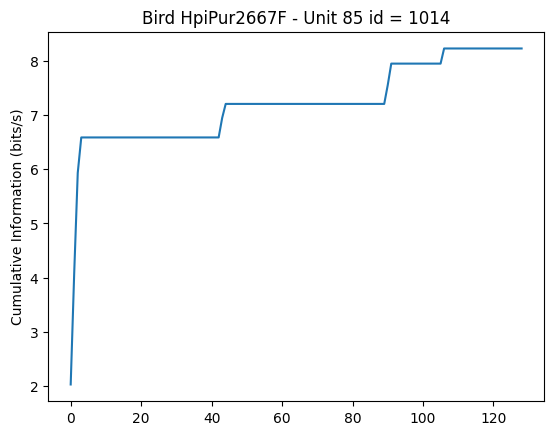

/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_78122/495951639.py:11: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

Unit 1014 found in Bird HpiPur2667F - Unit 85: SNR=1.0560268414686038, Info=6.587551061004611, Rate=3.051791039660453, Data size=2328.2907307239907 spikes


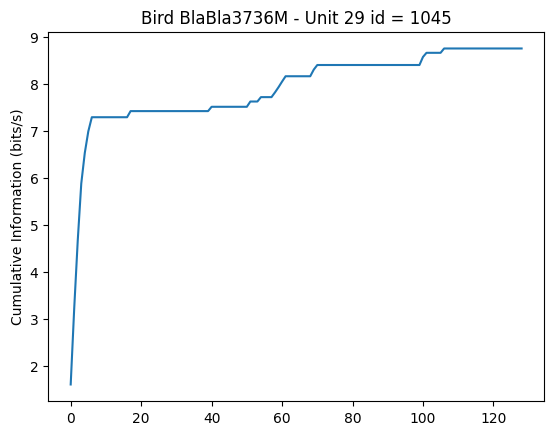

Unit 1045 found in Bird BlaBla3736M - Unit 29: SNR=1.2089784242617583, Info=7.290603870902894, Rate=1.4632716982106289, Data size=2118.9930116127757 spikes


/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_78122/495951639.py:11: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataFrame  = pkl.load(infile)
/Users/frederictheunissen/opt/anaconda3/envs/spikesort/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

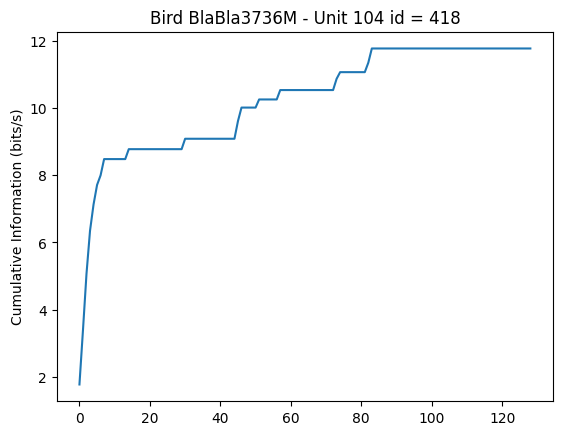

Unit 418 found in Bird BlaBla3736M - Unit 104: SNR=1.9897697360268354, Info=8.4836877669742, Rate=1.7258354109170844, Data size=1137.567152751887 spikes


In [20]:
# Plot the information for these neurons

for i_unit in units_to_label:
        bird  = birds[i_unit]
        unit = units[i_unit]

        # Read that data file and get the row. 
       
        file_path = os.path.join(data_dir, bird + '_' + nwbFiles[i_unit] + '_results.pkl')
        with open(file_path, 'rb') as infile:
                dataFrame  = pkl.load(infile)
        for i, row in dataFrame.iterrows():
                if row['unit'] == unit:
                        plt.figure()
                        plt.plot(row['cumInfo'])
                        plt.title(f'Bird {bird} - Unit {unit} id = {i_unit}') 
                        plt.ylabel('Cumulative Information (bits/s)')
                        plt.show()
                        print(f"Unit {i_unit} found in Bird {birds[i_unit]} - Unit {units[i_unit]}: SNR={snrs[i_unit]}, Info={infos[i_unit]}, Rate={rate[i_unit]}, Data size={rate[i_unit]*data_length[i_unit]/1000} spikes")
                        break



/var/folders/zn/qkxxn59x2712k0l7j64f7ry40000gn/T/ipykernel_78122/2349416465.py:32: RuntimeWarning: divide by zero encountered in divide
  idx_model = idx & (r2segIds/r2Ceils > r2_threshold)


Number of units with encoding models above 5% (R2 (corrected) > 0.2): 410/526


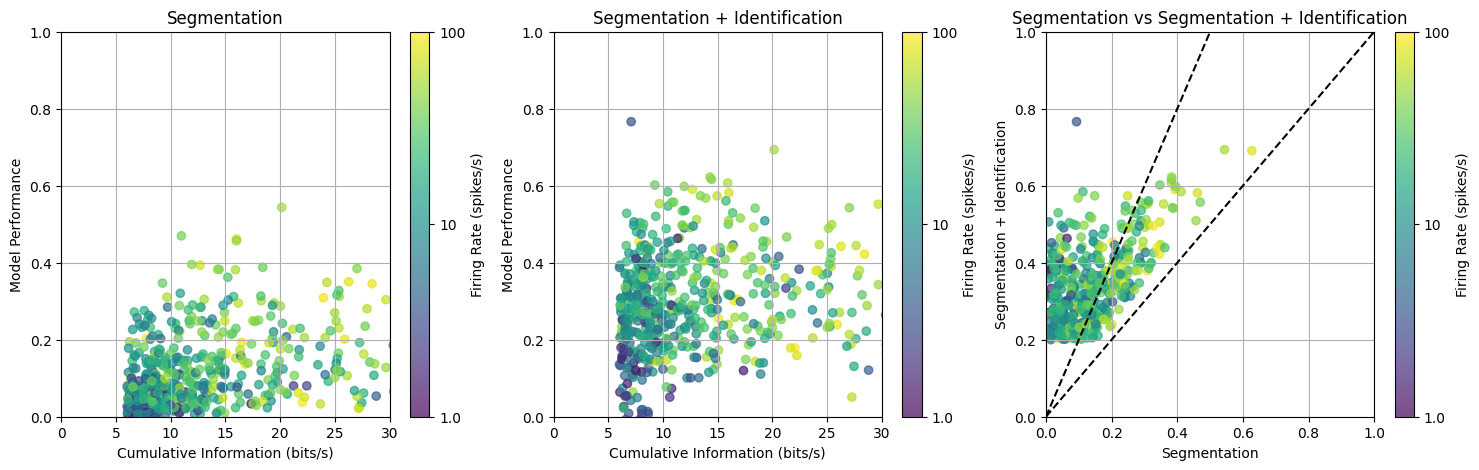

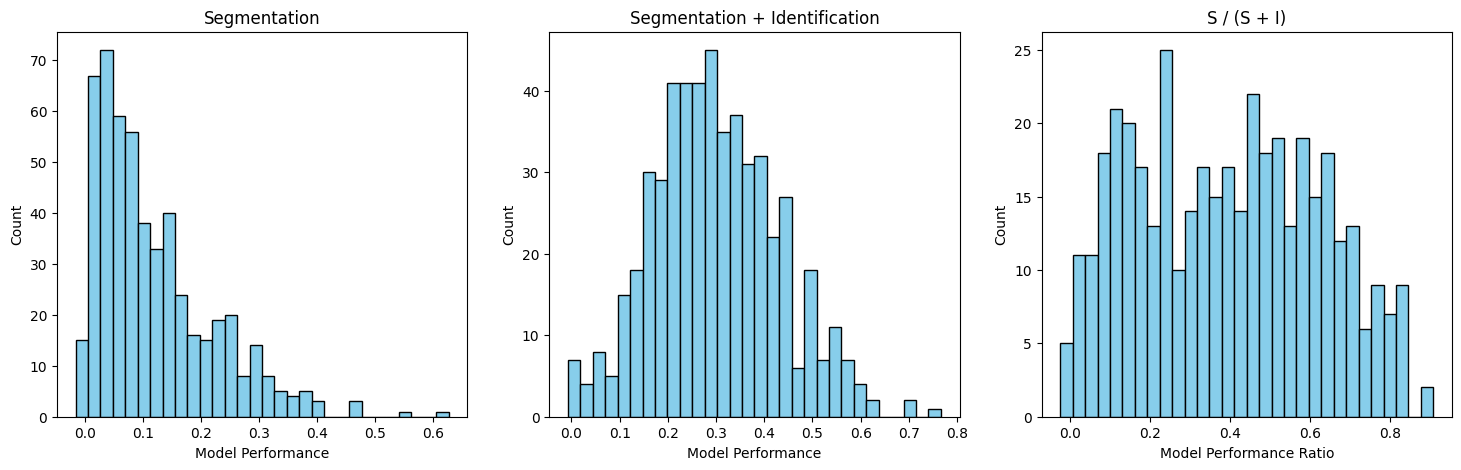

S Model Performance for bs: 0.15 +- 0.005, ns: 0.07 +- 0.009
T-test between unit types bs and ns: t-statistic = 7.540, p-value = 3.95e-11
S +I Model Performance for bs: 0.35 +- 0.006, ns: 0.33 +- 0.014
T-test between unit types bs and ns: t-statistic = 1.067, p-value = 0.29
Performance Ratio for bs: 0.42 +- 0.012, ns: 0.22 +- 0.025
T-test between unit types bs and ns: t-statistic = 7.184, p-value = 6.42e-10


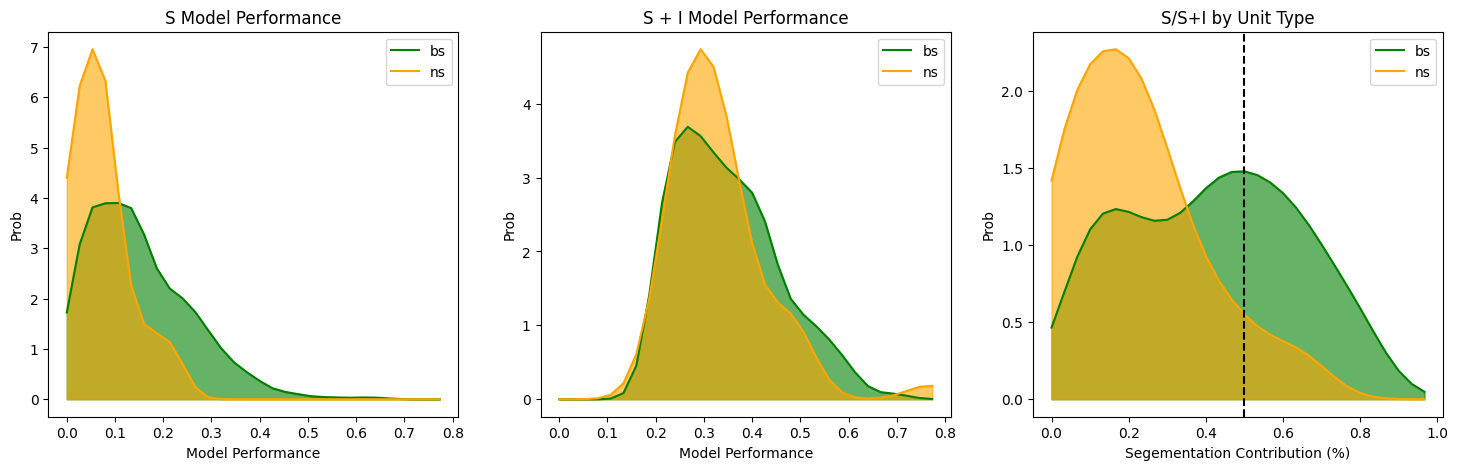

In [46]:
# Make scatter plots of model performance vs information

plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
plt.scatter(infos[idx], r2Segs[idx]/r2Ceils[idx], c = np.log10(rate[idx]), cmap ='viridis', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.title('Segmentation')
plt.xlabel('Cumulative Information (bits/s)')
plt.ylabel('Model Performance')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.xlim((0.0, 30.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.subplot(1,3,2)
plt.scatter(infos[idx], r2segIds[idx]/r2Ceils[idx], c = np.log10(rate[idx]), cmap ='viridis', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.title('Segmentation + Identification')
plt.xlabel('Cumulative Information (bits/s)')
plt.ylabel('Model Performance')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.xlim((0.0, 30.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

# Units predicted by encoding model
r2_threshold = 0.2
idx_model = idx & (r2segIds/r2Ceils > r2_threshold)
print(f"Number of units with encoding models above 5% (R2 (corrected) > {r2_threshold}): {np.sum(idx_model)}/{np.sum(idx)}")

plt.subplot(1,3,3)
plt.scatter(r2Segs[idx_model]/r2Ceils[idx_model], r2segIds[idx_model]/r2Ceils[idx_model], c = np.log10(rate[idx_model]), cmap ='viridis', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [0, 2], 'k--')
plt.title('Segmentation vs Segmentation + Identification')
plt.xlabel('Segmentation')
plt.ylabel('Segmentation + Identification')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.show()

# Histograms of model performance

plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
plt.hist(r2Segs[idx]/r2Ceils[idx], bins=30, color='skyblue', edgecolor='black')
plt.title('Segmentation')
plt.xlabel('Model Performance')
plt.ylabel('Count')

plt.subplot(1,3,2)
plt.hist(r2segIds[idx]/r2Ceils[idx], bins=30, color='skyblue', edgecolor='black')
plt.title('Segmentation + Identification')
plt.xlabel('Model Performance')
plt.ylabel('Count')

plt.subplot(1,3,3)
plt.hist((r2Segs[idx_model])/r2segIds[idx_model], bins=30, color='skyblue', edgecolor='black')
plt.title('S / (S + I)')
plt.xlabel('Model Performance Ratio')
plt.ylabel('Count')


plt.show()

# Histograms of model performance stacked by unit type
plt.figure(figsize=(18, 5))
ax = plt.subplot(1,3,1)
bins = np.arange(0, 0.8, 0.8/30)
idx_bs = idx_model & (unit_types == 'bs')
idx_ns = idx_model & (unit_types == 'ns')
list_of_data = [r2Segs[idx_bs]/r2Ceils[idx_bs], r2Segs[idx_ns]/r2Ceils[idx_ns]]
labels = ['bs', 'ns']
colors = ['green', 'orange']
kernel_bs = stats.gaussian_kde(list_of_data[0])
kernel_ns = stats.gaussian_kde(list_of_data[1])
ax.plot(bins, kernel_bs(bins), color=colors[0], label=labels[0], alpha= 1.0)
ax.fill_between(bins, kernel_bs(bins), color=colors[0], alpha=0.6)
ax.plot(bins, kernel_ns(bins), color=colors[1], label=labels[1], alpha= 1.0)
ax.fill_between(bins, kernel_ns(bins), color=colors[1], alpha=0.6)
# ax.hist(list_of_data[0], bins=bins, density = True, stacked=False, label=labels[0], color=colors[0], alpha=0.8)
# # freq, bins, patches = ax.hist(list_of_data[1], bins=bins, weights=-np.ones_like(list_of_data[1]), density = True, stacked=False, label=labels[1], color=colors[1], alpha=0.8)
# freq, bins = np.histogram(list_of_data[1], bins=bins, density = True)
# ax.bar(bins[:-1], -freq, width=np.diff(bins), align='edge', color=colors[1], alpha=0.8, label=labels[1])
# ax.axhline(0, color="k")
plt.legend()
plt.title('S Model Performance')
plt.xlabel('Model Performance')
plt.ylabel('Prob')
t_stat, p_val = stats.ttest_ind(list_of_data[0], list_of_data[1], equal_var=False)
print(f"S Model Performance for bs: {np.mean(list_of_data[0]):.2f} +- {np.std(list_of_data[0])/np.sqrt(len(list_of_data[0])):.3f}, ns: {np.mean(list_of_data[1]):.2f} +- {np.std(list_of_data[1])/np.sqrt(len(list_of_data[1])):.3f}")
print(f"T-test between unit types bs and ns: t-statistic = {t_stat:.3f}, p-value = {p_val:.3g}")


plt.subplot(1,3,2)
bins = np.arange(0, 0.8, 0.8/30)
list_of_data = [r2segIds[idx_bs]/r2Ceils[idx_bs], r2segIds[idx_ns]/r2Ceils[idx_ns]]
ax = plt.gca()
kernel_bs = stats.gaussian_kde(list_of_data[0])
kernel_ns = stats.gaussian_kde(list_of_data[1])
ax.plot(bins, kernel_bs(bins), color=colors[0], label=labels[0], alpha= 1.0)
ax.fill_between(bins, kernel_bs(bins), color=colors[0], alpha=0.6)
ax.plot(bins, kernel_ns(bins), color=colors[1], label=labels[1], alpha= 1.0)
ax.fill_between(bins, kernel_ns(bins), color=colors[1], alpha=0.6)
# ax.hist(list_of_data[0], bins=bins, density = True, stacked=False, label=labels[0], color=colors[0], alpha=0.8)
# freq, bins = np.histogram(list_of_data[1], bins=bins, density = True)
# ax.bar(bins[:-1], -freq, width=np.diff(bins), align='edge', color=colors[1], alpha=0.8, label=labels[1])
# ax.axhline(0, color="k")
plt.legend()
plt.title('S + I Model Performance')
plt.xlabel('Model Performance')
plt.ylabel('Prob')
t_stat, p_val = stats.ttest_ind(list_of_data[0], list_of_data[1], equal_var=False)
print(f"S +I Model Performance for bs: {np.mean(list_of_data[0]):.2f} +- {np.std(list_of_data[0])/np.sqrt(len(list_of_data[0])):.3f}, ns: {np.mean(list_of_data[1]):.2f} +- {np.std(list_of_data[1])/np.sqrt(len(list_of_data[1])):.3f}")
print(f"T-test between unit types bs and ns: t-statistic = {t_stat:.3f}, p-value = {p_val:.3g}")


ax = plt.subplot(1,3,3)
bins = np.arange(0, 1, 1/30)
idx_model_bs = idx_model & (unit_types == 'bs')
idx_model_ns = idx_model & (unit_types == 'ns')
list_of_data = [(r2Segs[idx_model_bs])/r2segIds[idx_model_bs], (r2Segs[idx_model_ns])/r2segIds[idx_model_ns]]
kernel_bs = stats.gaussian_kde(list_of_data[0])
kernel_ns = stats.gaussian_kde(list_of_data[1])
ax.plot(bins, kernel_bs(bins), color=colors[0], label=labels[0], alpha= 1.0)
ax.fill_between(bins, kernel_bs(bins), color=colors[0], alpha=0.6)
ax.plot(bins, kernel_ns(bins), color=colors[1], label=labels[1], alpha= 1.0)
ax.fill_between(bins, kernel_ns(bins), color=colors[1], alpha=0.6)
ax.axvline(0.5, color="k", linestyle='--')

#ax.hist(list_of_data[0], bins=bins, density = True, stacked=False, label=labels[0], color=colors[0], alpha=0.8)
# freq, bins = np.histogram(list_of_data[1], bins=bins, density = True)
# ax.bar(bins[:-1], -freq, width=np.diff(bins), align='edge', color=colors[1], alpha=0.8, label=labels[1])
#ax.axhline(0, color="k")
# ax.axvline(1.5, color="k", linestyle='--')
# ax.axvline(2.5, color="k", linestyle='--')

plt.legend()
plt.title('S/S+I by Unit Type')
plt.xlabel('Segementation Contribution (%)')
plt.ylabel('Prob')
t_stat, p_val = stats.ttest_ind(list_of_data[0], list_of_data[1], equal_var=False)
print(f"Performance Ratio for bs: {np.mean(list_of_data[0]):.2f} +- {np.std(list_of_data[0])/np.sqrt(len(list_of_data[0])):.3f}, ns: {np.mean(list_of_data[1]):.2f} +- {np.std(list_of_data[1])/np.sqrt(len(list_of_data[1])):.3f}")
print(f"T-test between unit types bs and ns: t-statistic = {t_stat:.3f}, p-value = {p_val:.3g}")



plt.show()

In [66]:
# Using a 50% cuttfoff for segmentation contribution to define "segmentation-predicted" units, how many of each type do we have?
segmentation_predicted_idx = idx_model & ((r2Segs/r2segIds) > 0.5)
print(f"Number of segmentation-predicted units (S/S+I > 0.5): {np.sum(segmentation_predicted_idx)}/{np.sum(idx_model)}")
nseg_bs = np.sum(segmentation_predicted_idx & (unit_types == 'bs'))
nseg_ns = np.sum(segmentation_predicted_idx & (unit_types == 'ns'))
nnonseg_bs = np.sum(idx_model & (unit_types == 'bs')) - nseg_bs
nnonseg_ns = np.sum(idx_model & (unit_types == 'ns')) - nseg_ns
table = np.array([[nseg_bs, nnonseg_bs], [nseg_ns, nnonseg_ns]])

print(f"Number of bs units among segmentation-predicted: {nseg_bs}/{nseg_bs + nnonseg_bs}  ({100.0*nseg_bs/(nseg_bs + nnonseg_bs):.0f} %)")
print(f"Number of ns units among segmentation-predicted: {nseg_ns}/{nseg_ns + nnonseg_ns}  ({100.0*nseg_ns/(nseg_ns + nnonseg_ns):.0f} %)")  


oddsratio, pvalue = stats.fisher_exact(table, alternative='two-sided')

print(f"Odds ratio: {oddsratio}")
print(f"P-value: {pvalue}")

Number of segmentation-predicted units (S/S+I > 0.5): 144/410
Number of bs units among segmentation-predicted: 141/363  (39 %)
Number of ns units among segmentation-predicted: 3/47  (6 %)
Odds ratio: 9.315315315315315
P-value: 2.5009948311639537e-06


### The difference in Performance ratio between unit types cannot just be explained by differences in rates.

LR statistic for Unit type effect: 9.36687870468154 with p-value 0.0022094142717169626 and df difference 1.0
                            OLS Regression Results                            
Dep. Variable:      performance_ratio   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     36.76
Date:                Fri, 06 Feb 2026   Prob (F-statistic):           2.11e-15
Time:                        16:38:53   Log-Likelihood:                 57.914
No. Observations:                 410   AIC:                            -109.8
Df Residuals:                     407   BIC:                            -97.78
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------

Text(0.5, 1.0, 'Segmentation Contribution vs Firing Rate')

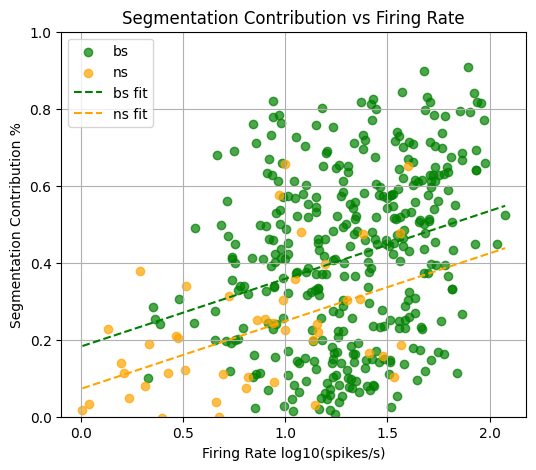

In [65]:
# Look at regression between Performance Ratio and Firing Rate and cell type
# Perform linear regression with interaction between rate and cell type
df_model = pd.DataFrame({
    'rate': np.log10(rate[idx_model]),
    'unit_type': unit_types[idx_model],
    'performance_ratio': (r2Segs[idx_model])/r2segIds[idx_model]
})  
model_full = smf.ols('performance_ratio ~ rate * unit_type', data=df_model).fit()
model_type = smf.ols('performance_ratio ~ rate + unit_type', data=df_model).fit()
model_rate = smf.ols('performance_ratio ~ rate', data=df_model).fit()

lr_statistic, p_value, df_diff = model_type.compare_lr_test(model_rate)
print(f"LR statistic for Unit type effect: {lr_statistic} with p-value {p_value} and df difference {df_diff}")
print(model_type.summary())

lr_statistic, p_value, df_diff = model_full.compare_lr_test(model_type)
print(f"LR statistic for Interaction effect: {lr_statistic} with p-value {p_value} and df difference {df_diff}")
print(model_full.summary())

plt.figure(figsize=(6, 5))
idx_model_bs = idx_model & (unit_types == 'bs')
idx_model_ns = idx_model & (unit_types == 'ns')
plt.scatter(np.log10(rate[idx_model_bs]), (r2Segs[idx_model_bs])/r2segIds[idx_model_bs], c = colors[0], alpha=0.7, label='bs')
plt.scatter(np.log10(rate[idx_model_ns]), (r2Segs[idx_model_ns])/r2segIds[idx_model_ns], c = colors[1], alpha=0.7, label='ns')  
b0_bs = model_type.params['Intercept'] 
b1_bs = model_type.params['rate']
b0_ns = model_type.params['Intercept'] + model_type.params['unit_type[T.ns]']
b1_ns = model_type.params['rate']
x_fit = np.linspace(np.log10(rate[idx_model].min()), np.log10(rate[idx_model].max()), 100)
y_fit_bs = b0_bs + b1_bs * x_fit
y_fit_ns = b0_ns + b1_ns * x_fit
plt.plot(x_fit, y_fit_bs, color=colors[0], linestyle='--', label='bs fit')
plt.plot(x_fit, y_fit_ns, color=colors[1], linestyle='--', label='ns fit')
plt.xlabel('Firing Rate log10(spikes/s)')
plt.ylabel('Segmentation Contribution %')
plt.ylim((0.0, 1.0))
plt.legend()
plt.grid(True)
plt.title('Segmentation Contribution vs Firing Rate')






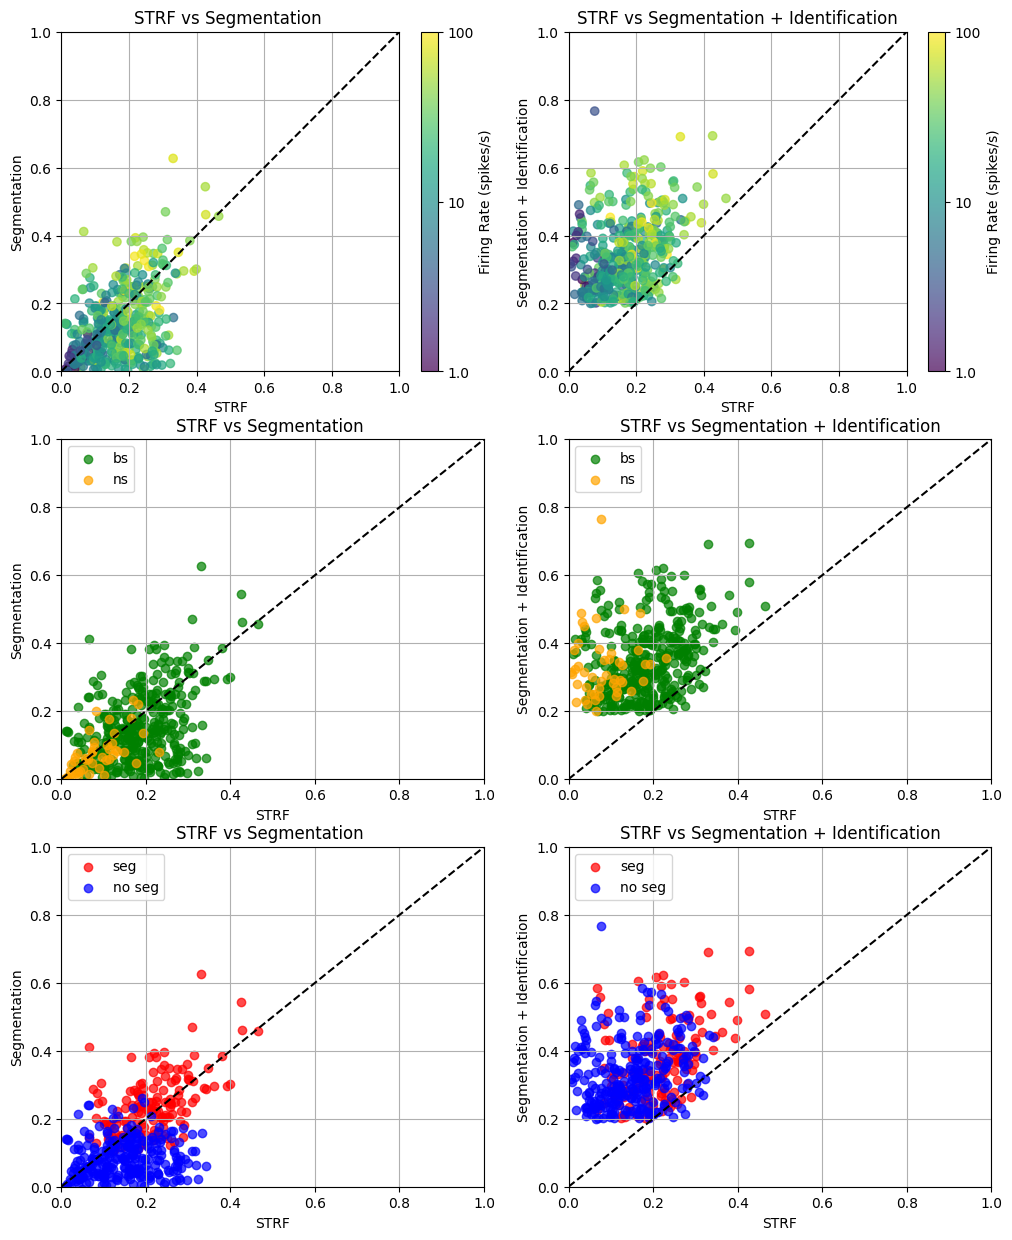

In [71]:
plt.figure(figsize=(12, 15))
plt.subplot(3,2,1)
plt.scatter(r2STRFs[idx_model]/r2Ceils[idx_model], r2Segs[idx_model]/r2Ceils[idx_model], c = np.log10(rate[idx_model]), cmap ='viridis', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('STRF vs Segmentation ')
plt.xlabel('STRF')
plt.ylabel('Segmentation')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.subplot(3,2,2)
plt.scatter(r2STRFs[idx_model]/r2Ceils[idx_model], r2segIds[idx_model]/r2Ceils[idx_model], c = np.log10(rate[idx_model]), cmap ='viridis', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('STRF vs Segmentation + Identification')
plt.xlabel('STRF')
plt.ylabel('Segmentation + Identification')
cbar = plt.colorbar(label='Firing Rate (spikes/s)')
tickvalues = cbar.get_ticks()
cbar.set_ticks([np.log10(rate_threshold), 1.0, 2.0])
cbar.set_ticklabels([rate_threshold, 10, 100])
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.subplot(3,2,3)
plt.scatter(r2STRFs[idx_model_bs]/r2Ceils[idx_model_bs], r2Segs[idx_model_bs]/r2Ceils[idx_model_bs], c = colors[0], alpha=0.7, label='bs')
plt.scatter(r2STRFs[idx_model_ns]/r2Ceils[idx_model_ns], r2Segs[idx_model_ns]/r2Ceils[idx_model_ns], c = colors[1], alpha=0.7, label='ns')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('STRF vs Segmentation ')
plt.xlabel('STRF')
plt.ylabel('Segmentation')
plt.legend()
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.subplot(3,2,4)
plt.scatter(r2STRFs[idx_model_bs]/r2Ceils[idx_model_bs], r2segIds[idx_model_bs]/r2Ceils[idx_model_bs], c = colors[0], alpha=0.7, label='bs')
plt.scatter(r2STRFs[idx_model_ns]/r2Ceils[idx_model_ns], r2segIds[idx_model_ns]/r2Ceils[idx_model_ns], c = colors[1], alpha=0.7, label='ns')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('STRF vs Segmentation + Identification')
plt.xlabel('STRF')
plt.ylabel('Segmentation + Identification')
plt.legend()
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

seg_idx = idx_model & ((r2Segs/r2segIds) > 0.5)
noseg_idx = idx_model & ((r2Segs/r2segIds) <= 0.5)

plt.subplot(3,2,5)
plt.scatter(r2STRFs[seg_idx]/r2Ceils[seg_idx], r2Segs[seg_idx]/r2Ceils[seg_idx], c = 'red', alpha=0.7, label='seg')
plt.scatter(r2STRFs[noseg_idx]/r2Ceils[noseg_idx], r2Segs[noseg_idx]/r2Ceils[noseg_idx], c = 'blue', alpha=0.7, label='no seg')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('STRF vs Segmentation ')
plt.xlabel('STRF')
plt.ylabel('Segmentation')
plt.legend()
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.subplot(3,2,6)
plt.scatter(r2STRFs[seg_idx]/r2Ceils[seg_idx], r2segIds[seg_idx]/r2Ceils[seg_idx], c = 'red', alpha=0.7, label='seg')
plt.scatter(r2STRFs[noseg_idx]/r2Ceils[noseg_idx], r2segIds[noseg_idx]/r2Ceils[noseg_idx], c = 'blue', alpha=0.7, label='no seg')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('STRF vs Segmentation + Identification')
plt.xlabel('STRF')
plt.ylabel('Segmentation + Identification')
plt.legend()
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.show()

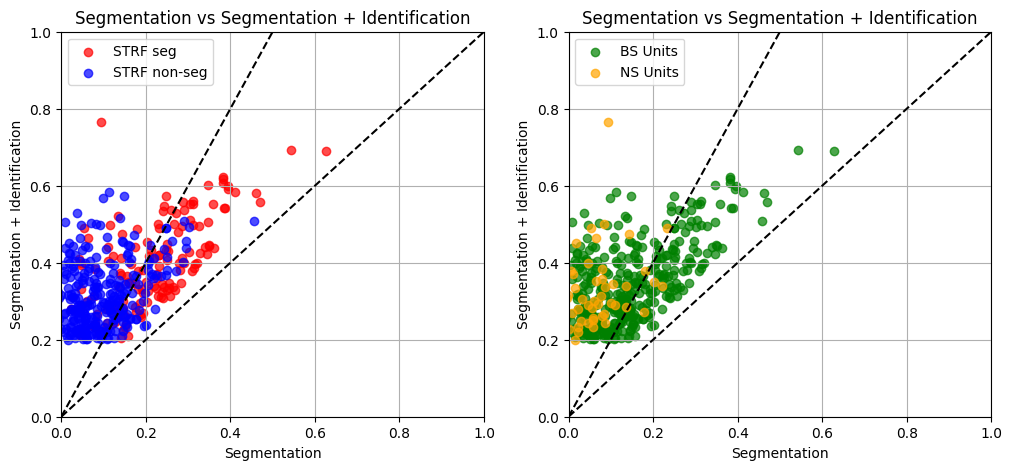

In [75]:
# I thought that comparing segmentation performance to STRF performance could be good way to determine segmentaiton only units but only kind of works.
# There are clearly segmentation + indentification units that are poorly moodeled with STRFs as well.

seg_idx = idx_model & (r2STRFs <= 1*r2Segs)
segId_idx = idx_model & (r2STRFs > 1*r2Segs)

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.scatter(r2Segs[seg_idx]/r2Ceils[seg_idx], r2segIds[seg_idx]/r2Ceils[seg_idx], c = 'red', alpha=0.7, label='STRF seg')
plt.scatter(r2Segs[segId_idx]/r2Ceils[segId_idx], r2segIds[segId_idx]/r2Ceils[segId_idx], c = 'blue', alpha=0.7, label='STRF non-seg')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [0, 2.0], 'k--')
plt.title('Segmentation vs Segmentation + Identification')
plt.xlabel('Segmentation')
plt.ylabel('Segmentation + Identification')
plt.legend(['Seg Units', 'SegID Units'])
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
bs_idx = idx_model & (unit_types == 'bs')
ns_idx = idx_model & (unit_types == 'ns')
plt.scatter(r2Segs[bs_idx]/r2Ceils[bs_idx], r2segIds[bs_idx]/r2Ceils[bs_idx], c = 'green', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.scatter(r2Segs[ns_idx]/r2Ceils[ns_idx], r2segIds[ns_idx]/r2Ceils[ns_idx], c = 'orange', alpha=0.7, clim=(np.log10(rate_threshold), 2.0))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [0, 2.0], 'k--')
plt.title('Segmentation vs Segmentation + Identification')
plt.xlabel('Segmentation')
plt.ylabel('Segmentation + Identification')
plt.legend(['BS Units', 'NS Units'])
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.grid(True)

plt.show()